In [1]:
import gc
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

In [2]:
from source_code.common import (log10, 
                                plot_figure, 
                                plot_slices, 
                                perform_op_over_data, 
                                get_margin_error)
from source_code.network import Network, free_device
from source_code.real_data_experiment import dataset_sampling, get_bounds_mnist

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
GAIN = 0.5
BIAS_VALUE = 0.5
DATA_MODE = 'mnist_bin'

In [27]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight, gain=GAIN)
        m.bias.data.fill_(BIAS_VALUE)

In [28]:
tr_mnist = pd.read_csv('./datasets/mnist_train.csv')
te_mnist = pd.read_csv('./datasets/mnist_train.csv')

In [78]:
tr_mnist_bin = tr_mnist[tr_mnist['label'].isin([8,9])].reset_index(drop=True)
te_mnist_bin = te_mnist[te_mnist['label'].isin([8,9])].reset_index(drop=True)

In [79]:
tr_mnist_bin['label'] = tr_mnist_bin.label.replace({8:0, 9:1})
te_mnist_bin['label'] = te_mnist_bin.label.replace({8:0, 9:1})

# Binary MNIST

In [266]:
# Hyperparams
FLAGS = {
    "batch_size": 1, 
    "input_dim": 784,
    "n_classes" : 2,
    "width" : 1000,
    "depth" : 2,
    "learning_rate" : 0.001,
    "threshold" : 0.01, # Proportion of training points can we ignore
    "margin" : 10, # Margin that needs to be achieved on most of the training points
    "n_test" : 4096,
    "n_train_list" : [512, 1024,2048, 4096, 8192], # To experiment with larger dataset sizes,
    "seed" : 8312
}

In [267]:
dir_path = './experiment_result/'
sub_dir_path =  dir_path + '{}_gain_{}_bias_{}_last(8_9)/'.format(DATA_MODE, GAIN, BIAS_VALUE)
FLAGS['path'] = sub_dir_path

In [268]:
test_error_path = FLAGS['path'] + 'test_error.png'
test_bound_path = FLAGS['path'] + 'test_error_bound.png'
test_norm_path = FLAGS['path'] + 'test_spectral_norm.png'

In [269]:
os.makedirs(dir_path, exist_ok=True)
os.makedirs(sub_dir_path, exist_ok=True)

In [270]:
init_model_3 = Network(**FLAGS)
init_model_3 = init_model_3.to(device)
torch.cuda.manual_seed(FLAGS['seed'])
torch.manual_seed(FLAGS['seed'])
init_model_3 = init_model_3.apply(init_weights)
initial_weights_3 = list(init_model_3.parameters())
initial_dict_3 = init_model_3.state_dict()
del init_model_3
gc.collect()

16241

In [271]:
# We sample a test set, and multiple independent draws of training sets of varying sizes
test_dataset = dataset_sampling(te_mnist_bin, FLAGS['n_test'], binary=True)

# Note that the function get_random_data is not visible in the blog, but can be found in the notebook after downloading
FLAGS["n_experiments"] = len(FLAGS["n_train_list"])
training_dataset_list = [[] for n_train in FLAGS["n_train_list"]]

for k in range(FLAGS["n_experiments"]):
    training_dataset_list[k] = dataset_sampling(tr_mnist_bin, FLAGS["n_train_list"][k], binary=True)

data shape :  (4096, 785)
data shape :  (512, 785)
data shape :  (1024, 785)
data shape :  (2048, 785)
data shape :  (4096, 785)
data shape :  (8192, 785)


In [278]:
final_weights_list = [[] for k in range(FLAGS["n_experiments"])] # Weights learned for each dataset size
final_dicts = [[] for k in range(FLAGS["n_experiments"])]
test_errors_list = [0 for k in range(FLAGS["n_experiments"])] # Test error for each dataset size

for k in range(FLAGS["n_experiments"]):
    print(f"\n[INFO] Experiment no. {k + 1} running...")
    
    # Define model
    model_3 = Network(**FLAGS)
    model_3 = model_3.to(device)
    model_3.load_state_dict(initial_dict_3)
    
    # Define criterion and optimizer
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.SGD(model_3.parameters(), lr=FLAGS["learning_rate"])
    
    # Train
    print(f"[INFO] ...training!")
    epoch = 0
    train_margin_error = 1.0
    
    while train_margin_error > FLAGS["threshold"]:
        epoch += 1
        outs = perform_op_over_data(model_3, training_dataset_list[k],\
                                    criterion, optimizer, device,
                                    batch_size=FLAGS["batch_size"])  
        train_margin_error = get_margin_error(model_3, training_dataset_list[k],\
                                              criterion, optimizer, \
                                              device, batch_size=FLAGS["batch_size"],\
                                              mode=DATA_MODE)
        print(f"[INFO] [EXP{str(k + 1).zfill(2)}] Epoch {epoch:2d}\n[INFO] [EXP{str(k + 1).zfill(2)}] current margin error: {train_margin_error:.4f}")
        
    # Compute test error
    print(f"[INFO] ...test!\n")
    test_errors_list[k] = get_margin_error(model_3, test_dataset, \
                                           criterion, optimizer,\
                                           device,batch_size=FLAGS['batch_size'],\
                                           mode=DATA_MODE
                                          ) 
    print(f"[INFO] test current margin error: {test_errors_list[k]:.4f}")
    final_weights_list[k] = list(model_3.parameters())
    final_dicts[k] = model_3.state_dict()
    torch.cuda.empty_cache()

In [274]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
colors = itertools.cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00'])
markers = itertools.cycle([ 'h', '*', '<', 'o', 's', 'v', 'D' ])

# change Matlab aesthetics
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)
mpl.rc('text', usetex=False)

def plot_figure(xtitle, ytitle, x, y, xticks, save_path, ylabels=None, x_transform=log10):
    fig = plt.figure(figsize=(10, 8))
    ax = plt.subplot(111)
    ax.set_xlabel(xtitle,fontsize=15)
    ax.set_xticks(log10(x))
    ax.set_xticklabels(xticks)
    ax.set_ylabel(f"log({ytitle})", fontsize=15)
        
    if ylabels is not None:
        for t in range(len(ylabels)):
            color = next(colors)
            marker = next(markers)
            ax.plot(x_transform(x), log10(y[t]), markersize=4, linestyle="-", marker=marker, color=color,label=ylabels[t], linewidth=1)
        ax.legend(fontsize=12)
    else:
        color = next(colors)
        marker = next(markers)
        ax.plot(x_transform(x), log10(y), markersize=4, linestyle="-", marker=marker, color=color, linewidth=1)
    plt.savefig(save_path)
    plt.show()

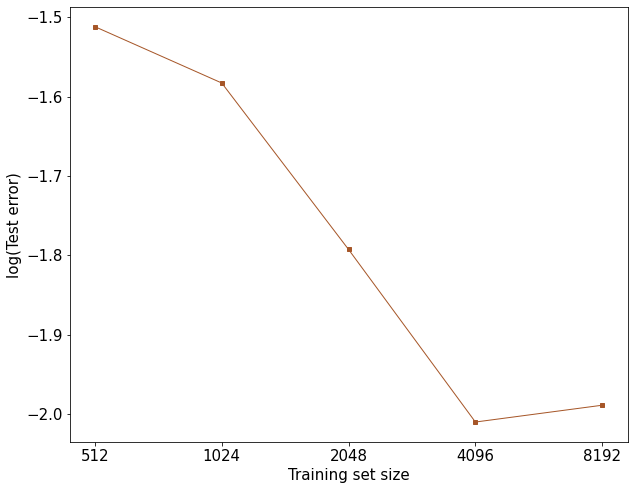

In [279]:
plot_figure("Training set size", "Test error", FLAGS["n_train_list"], 
            test_errors_list, xticks=FLAGS["n_train_list"], save_path=test_error_path)

In [276]:
bounds = [[],[],[]] 

for k in range(FLAGS["n_experiments"]):
    spectral_norms = [np.linalg.norm(w, ord=2) for w in free_device(final_weights_list[k])]
    bound_0, bound_1, bound_2 = get_bounds_mnist(free_device(initial_weights_3), free_device(final_weights_list[k]), \
                                                 spectral_norms, training_dataset_list[k].tensors[0], **FLAGS)
    bounds[0] += [bound_0]
    bounds[1] += [bound_1]
    bounds[2] += [bound_2]

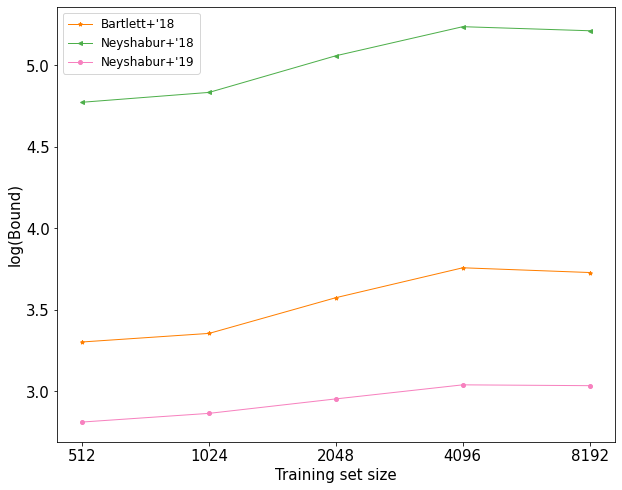

In [277]:
plot_figure("Training set size", "Bound", FLAGS["n_train_list"], bounds, xticks=FLAGS["n_train_list"], 
            save_path=test_bound_path,ylabels=["Bartlett+'18", "Neyshabur+'18", "Neyshabur+'19"])

In [227]:
import matplotlib.pyplot as plt

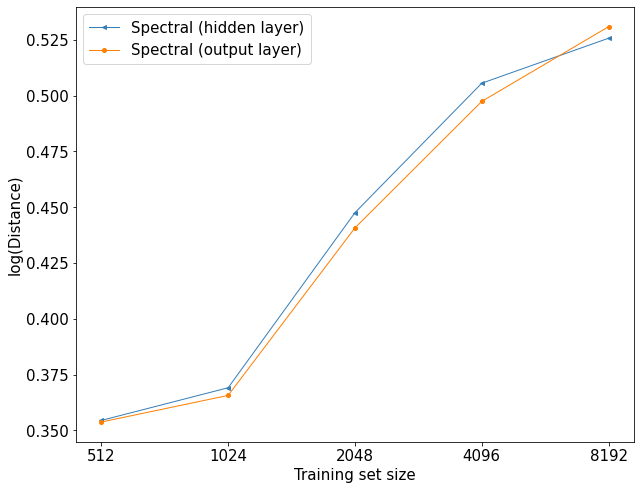

In [249]:
y_title = 'Distance'
xtitle = "Training set size"
xticks=FLAGS["n_train_list"]
x = FLAGS["n_train_list"]
y = [hidden_layer_spectral_norm, output_layer_spectral_norm]
ylabels=["Spectral (hidden layer)", "Spectral (output layer)"]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(xtitle,fontsize=15)
ax.set_xticks(log10(x))
ax.set_xticklabels(xticks)
ax.set_ylabel(f"log({y_title})", fontsize=15)
for t in range(len(ylabels)):
    color = next(colors)
    marker = next(markers)
    ax.plot(log10(x), log10(y[t]), markersize=4, linestyle="-", marker=marker, color=color,label=ylabels[t], linewidth=1)
ax.legend(fontsize=15)
plt.show()

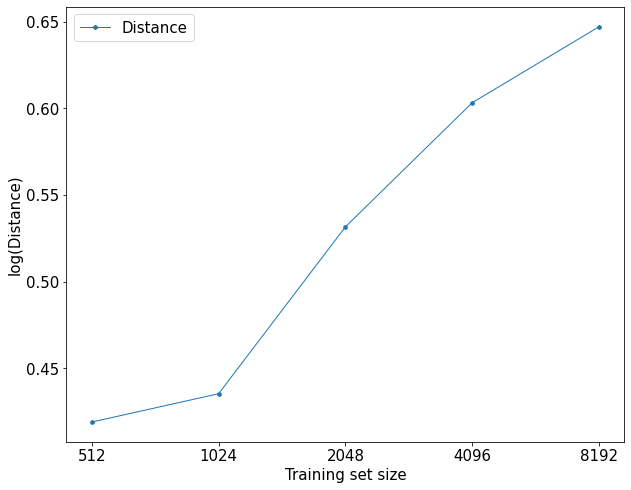

In [246]:
y_title = 'Distance'
xtitle = "Training set size"
xticks=FLAGS["n_train_list"]
x = FLAGS["n_train_list"]
y = distances
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(xtitle,fontsize=15)
ax.set_xticks(log10(x))
ax.set_xticklabels(xticks)
ax.set_ylabel(f"log({y_title})", fontsize=15)
ax.plot(log10(x), log10(y), markersize=4, linestyle="-", marker='h', color='tab:blue',label=y_title, linewidth=1)
ax.legend(fontsize=15)
plt.show()

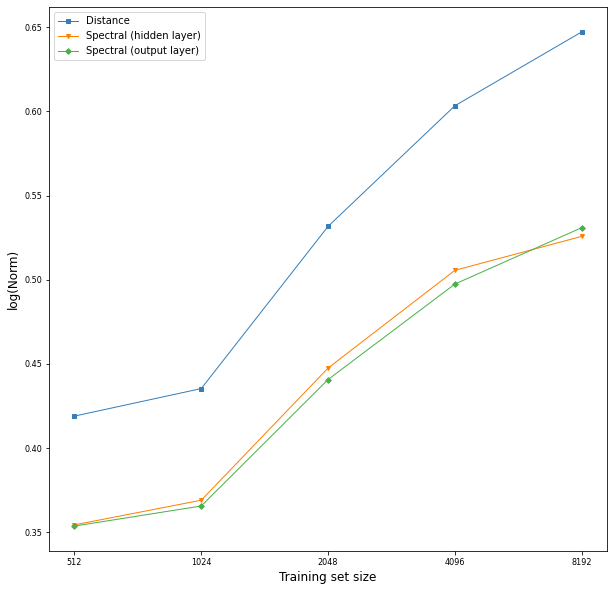

In [97]:
distances = [np.linalg.norm([np.linalg.norm(w[0] - w[1]) for w in zip(free_device(final_weights_list[k]), free_device(initial_weights_3))]) 
             for k in range(FLAGS["n_experiments"])]
hidden_layer_spectral_norm = [np.linalg.norm(free_device(final_weights_list[k])[0], ord=2) for k in range(FLAGS["n_experiments"])]
output_layer_spectral_norm = [np.linalg.norm(free_device(final_weights_list[k])[2], ord=2) for k in range(FLAGS["n_experiments"])]
plot_figure("Training set size", "Norm", FLAGS["n_train_list"],
            [distances, hidden_layer_spectral_norm, output_layer_spectral_norm],
            xticks=FLAGS["n_train_list"], 
            save_path=test_norm_path,
            ylabels=["Distance", "Spectral (hidden layer)", "Spectral (output layer)"])

In [287]:
# Hyperparams
FLAGS = {
    "batch_size": [1, 4, 16, 64, 256, 1024], 
    "input_dim": 784,
    "n_classes" : 2,
    "width" : 1000,
    "depth" : 2,
    "learning_rate" : 0.01,
    "threshold" : 0.03, # Proportion of training points can we ignore
    "margin" : 10, # Margin that needs to be achieved on most of the training points
    "n_train" : 8192,
    "n_test" : 4096,
    "seed" : 8312
}

In [288]:
dir_path = './experiment_result/'
sub_dir_path =  dir_path + '{}_gain_{}_bias_{}_last(8_9)_batch/'.format(DATA_MODE, GAIN, BIAS_VALUE)
FLAGS['path'] = sub_dir_path

In [289]:
os.makedirs(dir_path, exist_ok=True)
os.makedirs(sub_dir_path, exist_ok=True)

In [290]:
test_error_path = FLAGS['path'] + 'test_error.png'
test_bound_path = FLAGS['path'] + 'test_error_bound.png'
test_norm_path = FLAGS['path'] + 'test_spectral_norm.png'
test_distance_path = FLAGS['path'] + 'test_distance.png'

In [205]:
init_model_4 = Network(**FLAGS)
init_model_4 = init_model_4.to(device)
torch.cuda.manual_seed(FLAGS['seed'])
torch.manual_seed(FLAGS['seed'])
init_model_4 = init_model_4.apply(init_weights)
initial_weights_4 = list(init_model_4.parameters())
initial_dict_4 = init_model_4.state_dict()
del init_model_4
gc.collect()

6003

In [291]:
# We sample a test set, and multiple independent draws of training sets of varying sizes
training_dataset_batch = dataset_sampling(tr_mnist_bin, FLAGS["n_train"], binary=True)
test_dataset_batch = dataset_sampling(te_mnist_bin, FLAGS['n_test'], binary=True)

# Note that the function get_random_data is not visible in the blog, but can be found in the notebook after downloading
FLAGS["n_experiments"] = len(FLAGS["batch_size"])

data shape :  (8192, 785)
data shape :  (4096, 785)


In [207]:
from torch.utils.data import DataLoader
from tqdm import tqdm

In [208]:
def perform_op_over_data_batch(model, dataset, criterion, optimizer, device, batch_size, eval=False):
    outs = []
    dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=True)
    
    if eval:
        model.eval()
    else:
        model.train()
        
    for idx, (inputs, labels) in tqdm(enumerate(dataloader), leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        if eval == False:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                outputs = model(inputs) 
        outs.append(outputs.detach().cpu())
    model_parameters = list(model.parameters())
    return outs, model_parameters

In [221]:
final_weights_list_batch = [[] for k in range(FLAGS["n_experiments"])] # Weights learned for each dataset size
# final_dicts_batch = [[] for k in range(FLAGS["n_experiments"])]
test_errors_list_batch = [0 for k in range(FLAGS["n_experiments"])] # Test error for each dataset size

for k in range(FLAGS["n_experiments"]):
    print(f"\n[INFO] Experiment no. {k + 1} running...")
    
    # Define model
    model_4 = Network(**FLAGS)
    model_4 = model_4.to(device)
    model_4.load_state_dict(initial_dict_4)
    
    # Define criterion and optimizer
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.SGD(model_4.parameters(), lr=FLAGS["learning_rate"])
    
    # Train
    print(f"[INFO] ...training! batch_size : ", str(FLAGS["batch_size"][k]))
    epoch = 0
    train_margin_error = 1.0
    
    while train_margin_error > FLAGS["threshold"]:
        epoch += 1
        outs, model_parameters = perform_op_over_data_batch(model_4, training_dataset_batch,\
                                        criterion, optimizer, device,
                                        batch_size=FLAGS["batch_size"][k])  
        train_margin_error = get_margin_error(model_4, training_dataset_batch,\
                                              criterion, optimizer, \
                                              device, batch_size=FLAGS["batch_size"][k],\
                                              mode=DATA_MODE)
        print(f"[INFO] [EXP{str(k + 1).zfill(2)}] Epoch {epoch:2d}\n[INFO] [EXP{str(k + 1).zfill(2)}] current margin error: {train_margin_error:.4f}")
        
    # Compute test error
    print(f"[INFO] ...test!\n")
    test_errors_list_batch[k] = get_margin_error(model_4, test_dataset_batch, \
                                           criterion, optimizer,\
                                           device,batch_size=FLAGS['batch_size'][k],\
                                           mode=DATA_MODE
                                          ) 
    print(f"[INFO] test current margin error: {test_errors_list_batch[k]:.4f}")
    final_weights_list_batch[k] = model_parameters
#     final_dicts_batch[k] = model_4.state_dict()
    torch.cuda.empty_cache()

In [261]:
test_errors_list_batch

[tensor(0.0205),
 tensor(0.0264),
 tensor(0.0298),
 tensor(0.0303),
 tensor(0.0303),
 tensor(0.0305)]

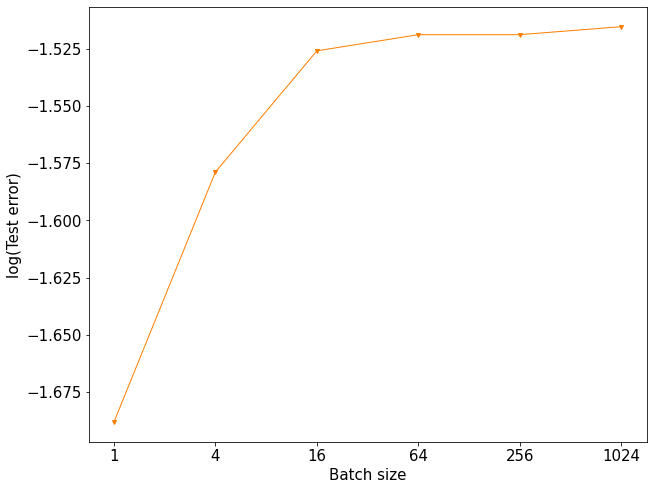

In [264]:
plot_figure("Batch size", "Test error", FLAGS["batch_size"], 
            test_errors_list_batch, xticks=FLAGS["batch_size"], save_path=test_error_path)

In [216]:
bounds_batchs = [[],[],[]] 

for k in range(FLAGS["n_experiments"]):
    spectral_norms = [np.linalg.norm(w, ord=2) for w in free_device(final_weights_list_batch[k])]
    bound_0_bat, bound_1_bat, bound_2_bat = get_bounds_mnist(free_device(initial_weights_4), free_device(final_weights_list_batch[k]), \
                                                             spectral_norms, training_dataset_batch.tensors[0], **FLAGS)
    bounds_batchs[0] += [bound_0_bat]
    bounds_batchs[1] += [bound_1_bat]
    bounds_batchs[2] += [bound_2_bat]

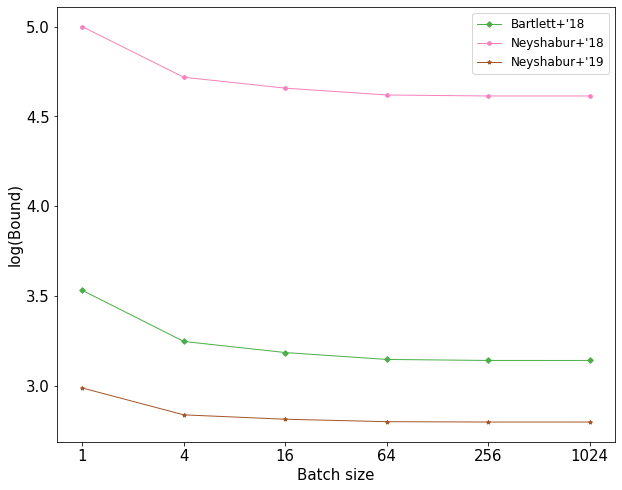

In [265]:
plot_figure("Batch size", "Bound", FLAGS["batch_size"], bounds_batchs, xticks=FLAGS["batch_size"], 
            save_path=test_bound_path,ylabels=["Bartlett+'18", "Neyshabur+'18", "Neyshabur+'19"])

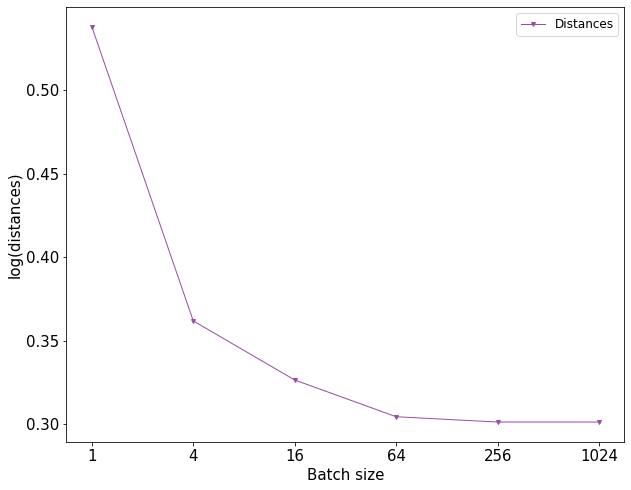

In [292]:
distances = [np.linalg.norm([np.linalg.norm(w[0] - w[-1]) for w in zip(free_device(final_weights_list_batch[k]), free_device(initial_weights_4))]) 
             for k in range(FLAGS["n_experiments"])]
plot_figure("Batch size", "distances", FLAGS["batch_size"],
            [distances],
            xticks=FLAGS["batch_size"], 
            save_path=test_distance_path,
            ylabels=["Distances"])

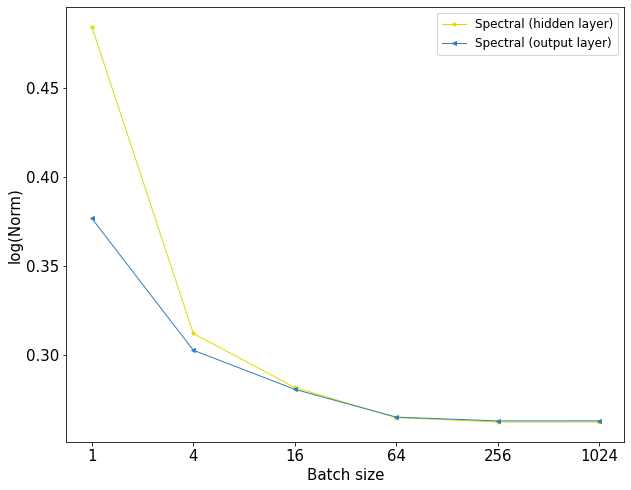

In [294]:
hidden_layer_spectral_norm = [np.linalg.norm(free_device(final_weights_list_batch[k])[0], ord=2) for k in range(FLAGS["n_experiments"])]
output_layer_spectral_norm = [np.linalg.norm(free_device(final_weights_list_batch[k])[2], ord=2) for k in range(FLAGS["n_experiments"])]
plot_figure("Batch size", "Norm", FLAGS["batch_size"],
            [hidden_layer_spectral_norm, output_layer_spectral_norm],
            xticks=FLAGS["batch_size"], 
            save_path=test_norm_path,
            ylabels=["Spectral (hidden layer)", "Spectral (output layer)"])